<a href="https://colab.research.google.com/github/elson-terakado/adult-census-income-classification/blob/main/Adult_Census_Income_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adult Census Income | Classification**


<a>
  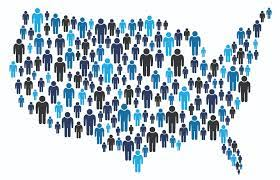
</a>

Output: predict if the income is greater or lower than 50K

In [ ]:
#!pip uninstall shap
!pip install shap

#!pip cache purge #(pra apagar cache de todos os seus pacotes)
#!pip cache remove shap #(apaga só do shap)

In [ ]:
!pip install requests beautifulsoup4

In [ ]:
!pip install selenium webdriver_manager

In [ ]:
!pip install gspread pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import requests
from bs4 import BeautifulSoup
#from selenium import webdriver
#from selenium.webdriver.chrome.service import Service as ChromeService
#from webdriver_manager.chrome import ChromeDriverManager
#from selenium.webdriver.chrome.options import Options

from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
filename = '/content/drive/MyDrive/Data_Science/adult-all.csv'
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education.num",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
    "native.country",
    "income"
]

df = pd.read_csv(filename, header=None, names=columns)
df.head(2)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [12]:
# Checking if it's an imbalanced data
count = df['income'].value_counts()
proportion = df['income'].value_counts(normalize=True)

result = pd.DataFrame({'Count': count, 'Proportion': proportion})

print(result)

       Count  Proportion
<=50K  37155    0.760718
>50K   11687    0.239282


# **Data Cleaning**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education.num   48842 non-null  int64 
 5   marital.status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital.gain    48842 non-null  int64 
 11  capital.loss    48842 non-null  int64 
 12  hours.per.week  48842 non-null  int64 
 13  native.country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [13]:
df = df.drop('fnlwgt', axis=1)
#df = df.drop('education', axis=1)
df.head(2)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [ ]:
df = df.drop_duplicates()
df.shape

(42468, 14)

In [ ]:
df.isnull().sum()

age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [ ]:
df.isna().sum()

age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

# **Splitting the dataset**

In [14]:
split_ratio = 0.8
train_df = df.sample(frac=split_ratio, random_state=42)
test_df = df.drop(train_df.index)

In [15]:
# Transform income into numeric
train_df['income'].replace('<=50K', 0, inplace=True)
train_df['income'].replace('>50K', 1, inplace=True)

test_df['income'].replace('<=50K', 0, inplace=True)
test_df['income'].replace('>50K', 1, inplace=True)

In [16]:
df['income'].replace('<=50K', 0, inplace=True)
df['income'].replace('>50K', 1, inplace=True)

# **EDA, Data Preparation and Feature Engineering**



## EDA Intro

In [ ]:
df.describe()

,age,education.num,capital.gain,capital.loss,hours.per.week
count,42468.000000,42468.000000,42468.000000,42468.000000,42468.000000
mean,39.476947,10.094801,1226.217128,99.859212,40.650702
std,13.779595,2.658658,7931.500736,429.072095,12.867960
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,29.000000,9.000000,0.000000,0.000000,38.000000
50%,38.000000,10.000000,0.000000,0.000000,40.000000
75%,49.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
df.head(2)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


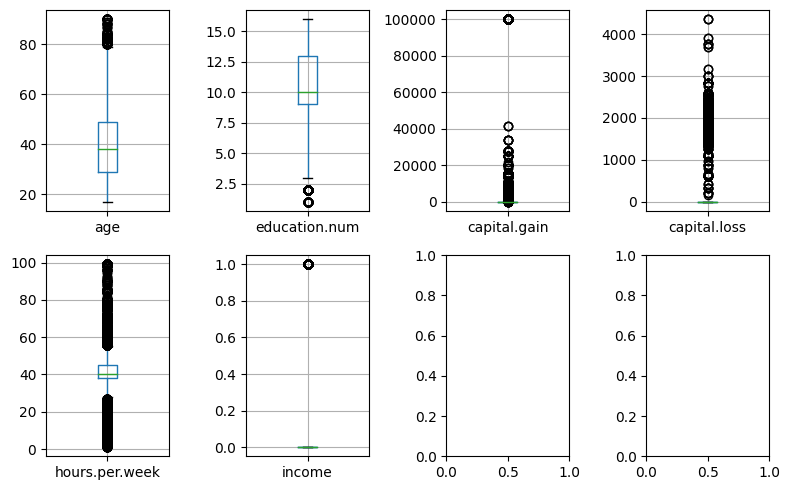

In [ ]:
# Distribution of continuous variables

continuous_vars =  [
    'age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'income'
    ]
fig, axes = plt.subplots(2,4) # create figure and axes

for i, el in enumerate(list(df[continuous_vars].columns.values)):
  a = df.boxplot(el, ax=axes.flatten()[i], fontsize='medium')

fig.set_size_inches(8, 5)
plt.tight_layout()

plt.show()

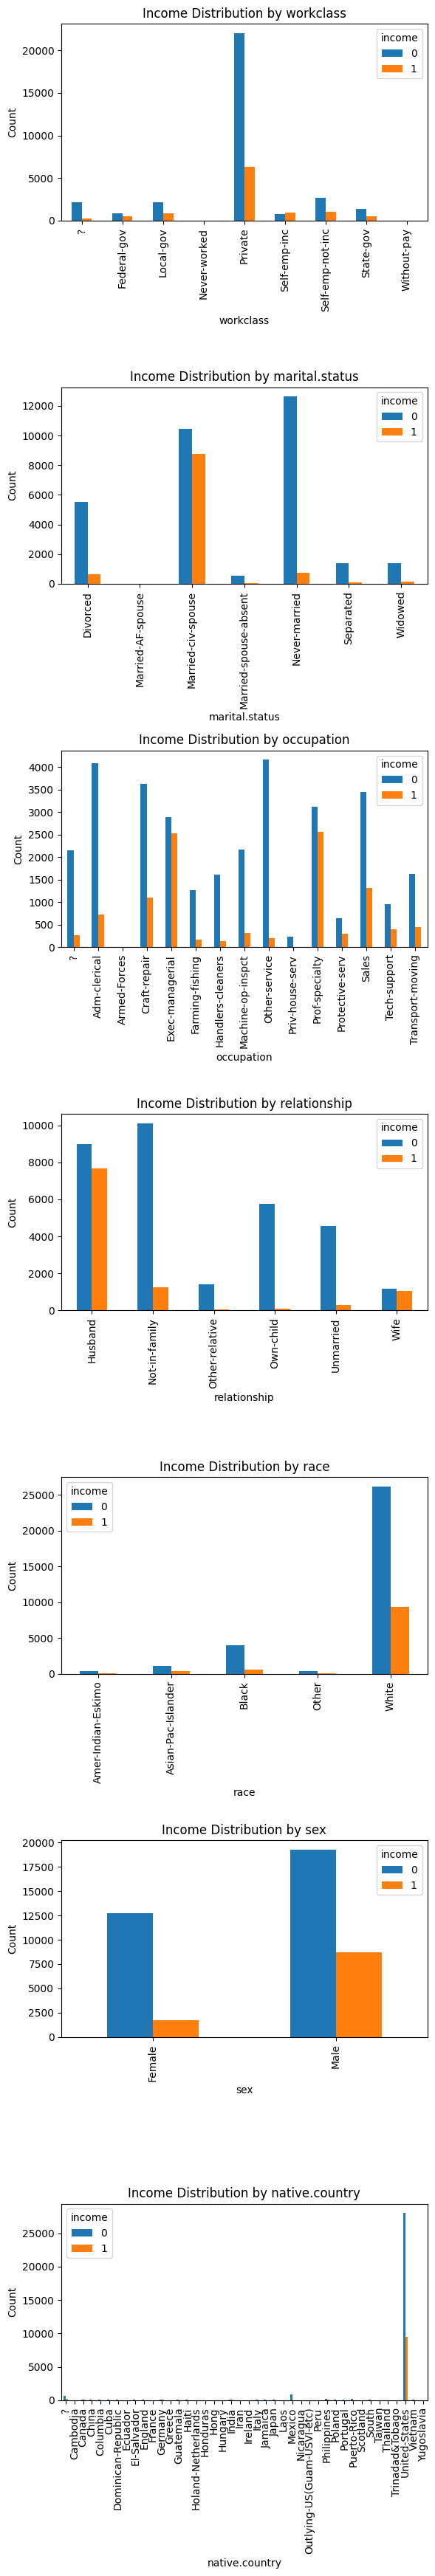

In [ ]:
continuous_vars =  ['workclass','marital.status','occupation','relationship','race','sex','native.country']

# Create subplots
fig, axs = plt.subplots(len(continuous_vars), figsize=(6, len(continuous_vars) * 5))

# Iterate over the categorical variables
for i, cat_var in enumerate(continuous_vars):
    # Group the data based on the categorical variable and calculate the count of each category for the binary variable
    grouped_data = df.groupby([cat_var, 'income']).size().unstack()

    # Plot the bar chart
    ax = axs[i]
    grouped_data.plot(kind='bar', stacked=False, ax=ax)

    # Set chart labels and title
    ax.set_xlabel(cat_var)
    ax.set_ylabel('Count')
    ax.set_title(f'Income Distribution by {cat_var}')

# Adjust the layout
plt.tight_layout()

# Show the chart
plt.show()

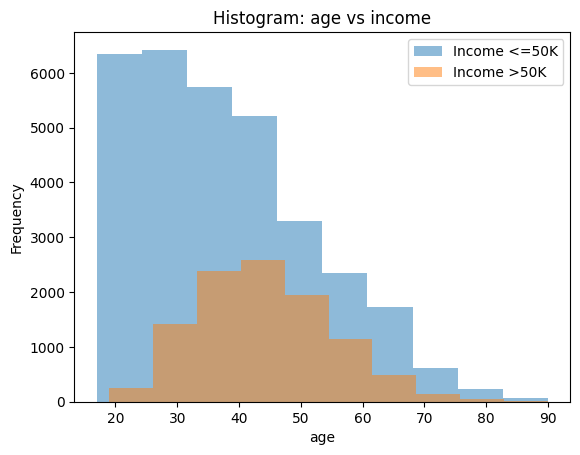

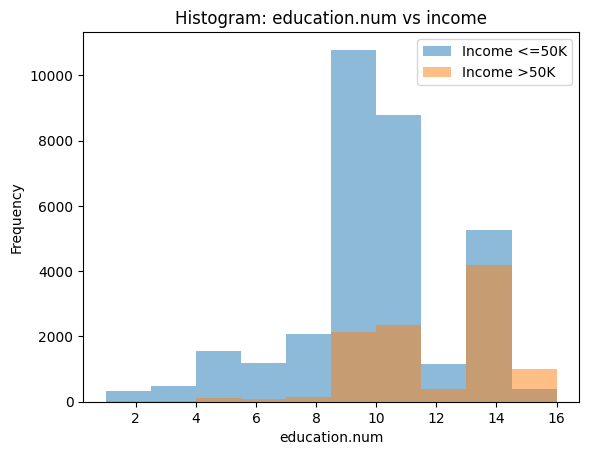

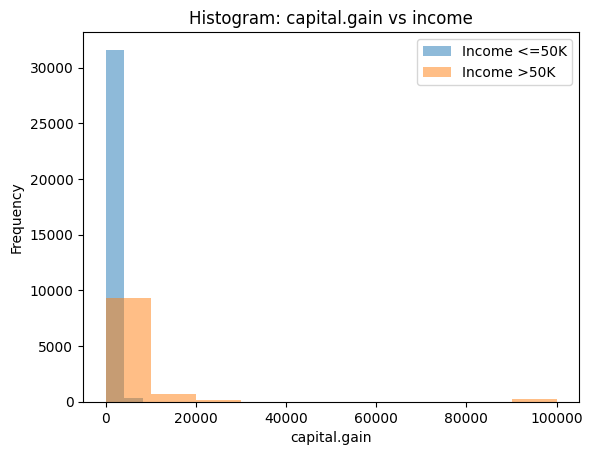

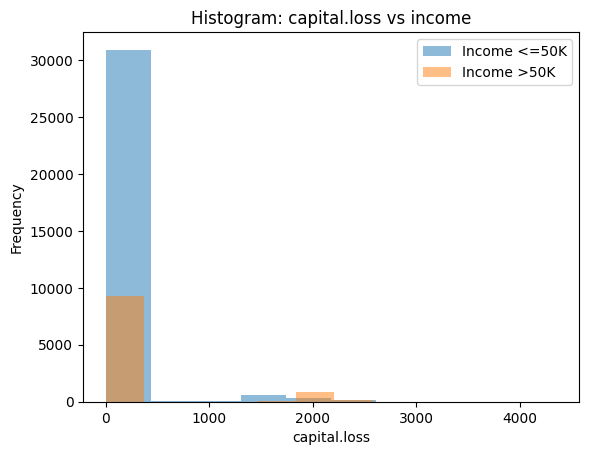

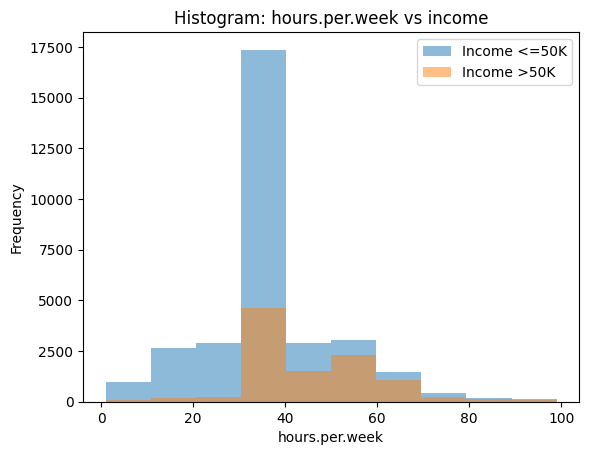

In [ ]:
# Define the list of columns and the income variable
columns = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
income_column = 'income'

# Create histograms for each column
for column in columns:
    # Separate the data based on income categories
    income_0 = df[df[income_column] == 0]
    income_1 = df[df[income_column] == 1]

    # Plot the histograms
    plt.hist(income_0[column], alpha=0.5, label='Income <=50K')
    plt.hist(income_1[column], alpha=0.5, label='Income >50K')

    # Set the plot labels and title
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f"Histogram: {column} vs {income_column}")

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [ ]:
df.corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,age,education.num,capital.gain,capital.loss,hours.per.week,income
age,1.000000,0.022846,0.072584,0.046617,0.036712,0.207333
education.num,0.022846,1.000000,0.127616,0.081789,0.134061,0.329616
capital.gain,0.072584,0.127616,1.000000,-0.035982,0.081645,0.233091
capital.loss,0.046617,0.081789,-0.035982,1.000000,0.051698,0.151477
hours.per.week,0.036712,0.134061,0.081645,0.051698,1.000000,0.222262
income,0.207333,0.329616,0.233091,0.151477,0.222262,1.000000


## Age

In [ ]:
df['age'].describe()

count    42468.000000
mean        39.476947
std         13.779595
min         17.000000
25%         29.000000
50%         38.000000
75%         49.000000
max         90.000000
Name: age, dtype: float64

In [17]:
'''
Infants (0-1 year), Toddlers (1-2 years), Toddlers (2-3 years), Preschoolers (3-5 years), Middle Childhood (6-8 years),
Middle Childhood (9-11 years), Young Teens (12-14 years), Teenagers (15-17 years)
young or early adulthood (approximately aged 20–39), middle adulthood (40–59), and old age (60+). Old age is typically divided into
the periods of young old (60–75) and old old (75 and up)
'''

def transform_to_categorical_age(df, column_name):
    # Define the age ranges and corresponding labels
    age_ranges = [(0, 17), (20, 39), (40, 59), (60, 74), (75, float('inf'))]
    age_labels = ['child_teenager', 'young_adulthodd', 'middle_adulthood', 'young_old', 'old_old']
    #age_labels = [1, 2, 3, 4, 5]

    # Apply the transformation and substitution
    df['age.category'] = pd.cut(df[column_name], bins=[0, 17, 39, 59, 74, float('inf')], labels=age_labels, include_lowest=True)

    return df

In [18]:
train_df = transform_to_categorical_age(train_df, 'age')
test_df = transform_to_categorical_age(test_df, 'age')

In [19]:
train_df = pd.get_dummies(train_df, columns=['age.category'])
test_df = pd.get_dummies(test_df, columns=['age.category'])

In [20]:
train_df = train_df.drop('age', axis=1)
test_df = test_df.drop('age', axis=1)

## Workclass

In [ ]:
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [21]:
train_df = pd.get_dummies(train_df, columns=['workclass'])
test_df = pd.get_dummies(test_df, columns=['workclass'])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33974 entries, 40654 to 38123
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   education                      33974 non-null  object
 1   education.num                  33974 non-null  int64 
 2   marital.status                 33974 non-null  object
 3   occupation                     33974 non-null  object
 4   relationship                   33974 non-null  object
 5   race                           33974 non-null  object
 6   sex                            33974 non-null  object
 7   capital.gain                   33974 non-null  int64 
 8   capital.loss                   33974 non-null  int64 
 9   hours.per.week                 33974 non-null  int64 
 10  native.country                 33974 non-null  object
 11  income                         33974 non-null  int64 
 12  age.category_child_teenager    33974 non-null  uint8 
 1

In [22]:
train_df = train_df.drop('workclass_?', axis=1)
test_df = test_df.drop('workclass_?', axis=1)

## Education & Education.num

In [ ]:
unique_values = df.groupby('education')['education.num'].unique()
unique_values.sort_values()

education
Preschool        [1]
1st-4th          [2]
5th-6th          [3]
7th-8th          [4]
9th              [5]
10th             [6]
11th             [7]
12th             [8]
HS-grad          [9]
Some-college    [10]
Assoc-voc       [11]
Assoc-acdm      [12]
Bachelors       [13]
Masters         [14]
Prof-school     [15]
Doctorate       [16]
Name: education.num, dtype: object

In [23]:
train_df = train_df.drop('education', axis=1)
test_df = test_df.drop('education', axis=1)

## Marital.status

In [24]:
train_df = pd.get_dummies(train_df, columns=['marital.status'])
test_df = pd.get_dummies(test_df, columns=['marital.status'])

## Occupation

In [ ]:
df['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [25]:
train_df = pd.get_dummies(train_df, columns=['occupation'])
test_df = pd.get_dummies(test_df, columns=['occupation'])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33974 entries, 40654 to 38123
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   education.num                         33974 non-null  int64 
 1   relationship                          33974 non-null  object
 2   race                                  33974 non-null  object
 3   sex                                   33974 non-null  object
 4   capital.gain                          33974 non-null  int64 
 5   capital.loss                          33974 non-null  int64 
 6   hours.per.week                        33974 non-null  int64 
 7   native.country                        33974 non-null  object
 8   income                                33974 non-null  int64 
 9   age.category_child_teenager           33974 non-null  uint8 
 10  age.category_young_adulthodd          33974 non-null  uint8 
 11  age.category_middle_adul

In [26]:
train_df = train_df.drop('occupation_?', axis=1)
test_df = test_df.drop('occupation_?', axis=1)

## Relationship

In [27]:
train_df = pd.get_dummies(train_df, columns=['relationship'])
test_df = pd.get_dummies(test_df, columns=['relationship'])

## Race

In [ ]:
df['race'].value_counts()

White                 35541
Black                  4536
Asian-Pac-Islander     1515
Amer-Indian-Eskimo      470
Other                   406
Name: race, dtype: int64

In [28]:
train_df = pd.get_dummies(train_df, columns=['race'])
test_df = pd.get_dummies(test_df, columns=['race'])

## Sex

In [29]:
train_df = pd.get_dummies(train_df, columns=['sex'])
test_df = pd.get_dummies(test_df, columns=['sex'])

## Capital.gain & Capital.loss

In [30]:
'''
Definition: Capital gain is the profit one earns on the sale of an asset like stocks, bonds or real estate. It results in capital gain when the
selling price of an asset exceeds its purchase price. It is the difference between the selling price (higher) and cost price (lower) of the asset.

A capital loss is the loss incurred when a capital asset, such as an investment or real estate, decreases in value. This loss is not realized
until the asset is sold for a price that is lower than the original purchase price.
'''

train_df['delta_capital'] = train_df['capital.gain'] - train_df['capital.loss']
test_df['delta_capital'] = test_df['capital.gain'] - test_df['capital.loss']

## Hours.per.week

In [ ]:
'''
Full-time employment is 35 hours or more per week.
Part-time employment is 1–34 hours per week.
Over-time: working more than 55 hours a week
'''

In [31]:
def transform_to_categorical_hpw(df, column_name):
    # Define the age ranges and corresponding labels
    hpw_ranges = [(0, 34), (35, 55), (56, float('inf'))]
    hpw_labels = ['Part-time', 'Full-time', 'Over-time']

    # Apply the transformation and substitution
    df['hpw.category'] = pd.cut(df[column_name], bins=[0, 34, 55, float('inf')], labels=hpw_labels, include_lowest=True)

    return df

In [32]:
train_df = transform_to_categorical_hpw(train_df, 'hours.per.week')
test_df = transform_to_categorical_hpw(test_df, 'hours.per.week')

In [33]:
train_df = pd.get_dummies(train_df, columns=['hpw.category'])
test_df = pd.get_dummies(test_df, columns=['hpw.category'])

In [34]:
train_df = train_df.drop('hours.per.week', axis=1)
test_df = test_df.drop('hours.per.week', axis=1)

## Native.country / continent

In [ ]:
df['native.country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [35]:
country_to_continent = {
    'United-States': 'North America',
    'Cuba': 'North America',
    'Jamaica': 'North America',
    'India': 'Asia',
    '?': 'Unknown',
    'Mexico': 'North America',
    'South': 'Asia',
    'Puerto-Rico': 'North America',
    'Honduras': 'North America',
    'England': 'Europe',
    'Canada': 'North America',
    'Germany': 'Europe',
    'Iran': 'Asia',
    'Philippines': 'Asia',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Columbia': 'South America',
    'Cambodia': 'Asia',
    'Thailand': 'Asia',
    'Ecuador': 'South America',
    'Laos': 'Asia',
    'Taiwan': 'Asia',
    'Haiti': 'North America',
    'Portugal': 'Europe',
    'Dominican-Republic': 'North America',
    'El-Salvador': 'North America',
    'France': 'Europe',
    'Guatemala': 'North America',
    'China': 'Asia',
    'Japan': 'Asia',
    'Yugoslavia': 'Europe',
    'Peru': 'South America',
    'Outlying-US(Guam-USVI-etc)': 'Oceania',
    'Scotland': 'Europe',
    'Trinadad&Tobago': 'North America',
    'Greece': 'Europe',
    'Nicaragua': 'North America',
    'Vietnam': 'Asia',
    'Hong': 'Asia',
    'Ireland': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe'
}

In [36]:
train_df['continent'] = train_df['native.country'].map(country_to_continent)
test_df['continent'] = test_df['native.country'].map(country_to_continent)

In [37]:
train_df = pd.get_dummies(train_df, columns=['continent'])
test_df = pd.get_dummies(test_df, columns=['continent'])

In [38]:
train_df = train_df.drop(['continent_Unknown'], axis=1)
test_df = test_df.drop(['continent_Unknown'], axis=1)

## New Variables with public data - HDI, years of schooling and GNI per capita

In [ ]:
'''
# I did a web scrapping at this step, but it stopped working

url = "https://www.nationsonline.org/oneworld/human_development.htm"
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

# Find the table with the class attribute 'countrystats'
table = soup.find('table', {'class': 'countrystats'})

if table is not None:
    data = []
    headers = []

    # Extract the table data
    for row in table.find_all('tr'):
        if not headers:
            headers = [header.text.strip() for header in row.find_all('th')]
        else:
            row_data = [cell.text.strip() for cell in row.find_all('td')]
            data.append(row_data)

    # Create a pandas DataFrame
    df_gdp = pd.DataFrame(data, columns=headers)

    print(df_gdp)
else:
    print("Table not found.")
'''

In [39]:
df_gdp = pd.read_csv('/content/drive/MyDrive/Data_Science/The Human Development Index 2016 csv.csv')
df_gdp.head(2)

,HDI rank,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank 2014
0,1,Norway,0.949,81.7,17.7,12.7,"67,614",5,1
1,2,Australia,0.939,82.5,20.4,13.2,"42,822",19,3


In [ ]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   HDI rank                                188 non-null    int64  
 1   Country                                 188 non-null    object 
 2   Human Development Index (HDI)           188 non-null    float64
 3   Life expectancy at birth                188 non-null    float64
 4   Expected years of schooling             188 non-null    float64
 5   Mean years of schooling                 188 non-null    float64
 6   Gross national income (GNI) per capita  188 non-null    object 
 7   GNI per capita rank minus HDI rank      188 non-null    int64  
 8   HDI rank 2014                           188 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 13.3+ KB


In [40]:
df_gdp = df_gdp.drop(['HDI rank','Life expectancy at birth','Expected years of schooling','GNI per capita rank minus HDI rank','HDI rank 2014'], axis=1)

In [ ]:
df_gdp.duplicated().sum()

0

In [ ]:
df_gdp.head(2)

,Country,Human Development Index (HDI),Mean years of schooling,Gross national income (GNI) per capita
0,Norway,0.949,12.7,"67,614"
1,Australia,0.939,13.2,"42,822"


In [41]:
df_gdp.rename(columns={'Human Development Index (HDI)': 'hdi', 'Mean years of schooling':'mean_years_school', 'Gross national income (GNI) per capita':'gni_per_capita'}, inplace=True)

In [ ]:
df_gdp

,Country,hdi,mean_years_school,gni_per_capita
0,Norway,0.949,12.7,"67,614"
1,Australia,0.939,13.2,"42,822"
2,Switzerland,0.939,13.4,"56,364"
3,Germany,0.926,13.2,"45,000"
4,Denmark,0.925,12.7,"44,519"
...,...,...,...,...
183,Burundi,0.404,3.0,691
184,Burkina Faso,0.402,1.4,"1,537"
185,Chad,0.396,2.3,"1,991"
186,Niger,0.353,1.7,889


In [42]:
df_gdp['gni_per_capita'] = df_gdp['gni_per_capita'].str.replace(',', '').astype(int)

In [ ]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            188 non-null    object 
 1   hdi                188 non-null    float64
 2   mean_years_school  188 non-null    float64
 3   gni_per_capita     188 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.0+ KB


In [ ]:
df_gdp.sort_values(by='Country', ascending=True)

,Country,hdi,mean_years_school,gni_per_capita
168,Afghanistan,0.479,3.6,1871
74,Albania,0.764,9.6,10252
82,Algeria,0.745,7.8,13533
31,Andorra,0.858,10.3,47979
149,Angola,0.533,5.0,6291
...,...,...,...,...
71,Venezuela,0.767,9.4,15129
114,Viet Nam,0.683,8.0,5335
167,Yemen,0.482,3.0,2300
140,Zambia,0.579,6.9,3464


In [ ]:
df['native.country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [43]:
train_df['native.country'] = train_df['native.country'].str.replace('-', ' ')
test_df['native.country'] = test_df['native.country'].str.replace('-', ' ')

In [44]:
train_df['hdi'] = train_df['native.country'].map(df_gdp.set_index('Country')['hdi'])
test_df['hdi'] = test_df['native.country'].map(df_gdp.set_index('Country')['hdi'])

train_df['mean_years_school'] = train_df['native.country'].map(df_gdp.set_index('Country')['mean_years_school'])
test_df['mean_years_school'] = test_df['native.country'].map(df_gdp.set_index('Country')['mean_years_school'])

train_df['gni_per_capita'] = train_df['native.country'].map(df_gdp.set_index('Country')['gni_per_capita'])
test_df['gni_per_capita'] = test_df['native.country'].map(df_gdp.set_index('Country')['gni_per_capita'])

In [ ]:
train_df['gni_per_capita'].unique()

array([53245.,  8395., 12756.,  4747.,    nan, 33573., 24808.,  5663.,
       16383., 26104., 13345.,  8350., 45000.,  3095.,  7455., 14519.,
        1657., 24117.,  7732., 42582., 38085., 23394.,  4466.,  7063.,
       10536., 16395., 37268., 11295.,  5049., 43798.])

In [45]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [46]:
train_df = train_df.drop(['native.country'], axis=1)
test_df = test_df.drop(['native.country'], axis=1)

# **Splitting the dataset**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33974 entries, 40654 to 38123
Data columns (total 63 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   education.num                         33974 non-null  int64  
 1   capital.gain                          33974 non-null  int64  
 2   capital.loss                          33974 non-null  int64  
 3   income                                33974 non-null  int64  
 4   age.category_child_teenager           33974 non-null  uint8  
 5   age.category_young_adulthodd          33974 non-null  uint8  
 6   age.category_middle_adulthood         33974 non-null  uint8  
 7   age.category_young_old                33974 non-null  uint8  
 8   age.category_old_old                  33974 non-null  uint8  
 9   workclass_Federal-gov                 33974 non-null  uint8  
 10  workclass_Local-gov                   33974 non-null  uint8  
 11  workclass_N

In [53]:
train_adult_income = train_df.to_csv(index=False)

csv_file_path = '/content/drive/MyDrive/Data_Science/train_adult_income.csv'

with open(csv_file_path, 'w', newline='') as csvfile:
    csvfile.write(train_adult_income)

print(f"CSV file has been successfully saved at '{csv_file_path}'.")

CSV file has been successfully saved at '/content/drive/MyDrive/Data_Science/train_adult_income.csv'.


In [54]:
test_adult_income = test_df.to_csv(index=False)

csv_file_path = '/content/drive/MyDrive/Data_Science/test_adult_income.csv'

with open(csv_file_path, 'w', newline='') as csvfile:
    csvfile.write(test_adult_income)

print(f"CSV file has been successfully saved at '{csv_file_path}'.")

CSV file has been successfully saved at '/content/drive/MyDrive/Data_Science/test_adult_income.csv'.


In [3]:
#train_df = pd.read_csv('/content/drive/MyDrive/Data_Science/train_adult_income.csv')
#test_df = pd.read_csv('/content/drive/MyDrive/Data_Science/test_adult_income.csv')

In [5]:
train_df = train_df.drop(['capital.gain', 'capital.loss'], axis=1)
test_df = test_df.drop(['capital.gain', 'capital.loss'], axis=1)

In [6]:
X_train = train_df.drop('income', axis=1)
y_train = train_df['income']

X_test = test_df.drop('income', axis=1)
y_test = test_df['income']

# **Model building & Evaluation**

In [9]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
    #'Support Vector Machines (SVM)': SVC(),
    #'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    #'Naive Bayes': GaussianNB()
}

In [11]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # X_train and y_train represent your training data
    y_pred = model.predict(X_test)  # X_test represents your test data
    accuracy = accuracy_score(y_test, y_pred)  # y_test represents the true values of the target variable
    results[name] = accuracy

In [12]:
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy}")

Logistic Regression: Accuracy = 0.812960687960688
Decision Tree: Accuracy = 0.8439803439803439
Random Forest: Accuracy = 0.8507371007371007


In [ ]:
models = {
    #'Logistic Regression': LogisticRegression(),
    #'Decision Tree': DecisionTreeClassifier(),
    #'Random Forest': RandomForestClassifier(),
    'Support Vector Machines (SVM)': SVC(),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # X_train and y_train represent your training data
    y_pred = model.predict(X_test)  # X_test represents your test data
    accuracy = accuracy_score(y_test, y_pred)  # y_test represents the true values of the target variable
    results[name] = accuracy

In [ ]:
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy}")

In [ ]:
# performance making the label encoder for every variable
'''
Logistic Regression: Accuracy = 0.8036445536445537
Decision Tree: Accuracy = 0.8251433251433251
Random Forest: Accuracy = 0.8505323505323505
Support Vector Machines (SVM): Accuracy = 0.8025184275184275
K-Nearest Neighbors (KNN): Accuracy = 0.8434684684684685
Naive Bayes: Accuracy = 0.797911547911548
'''
# performance making the right encoding for each variable(withoyt capital.gain and capital.loss, only GNI public data)
'''
Logistic Regression: Accuracy = 0.8457734871674123
Decision Tree: Accuracy = 0.8478926300918296
Random Forest: Accuracy = 0.8535436778902755
Support Vector Machines (SVM): Accuracy = 0.7999764539675065
K-Nearest Neighbors (KNN): Accuracy = 0.8567223922769014
Naive Bayes: Accuracy = 0.8030374381916647
'''
# final version
'''
Logistic Regression: Accuracy = 0.812960687960688
Decision Tree: Accuracy = 0.8455159705159705
Random Forest: Accuracy = 0.8508394758394758
'''

# **Treatment for imbalanced class**

# **SHAP**

In [13]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [14]:
explainer = shap.Explainer(model.predict, X_test)

In [15]:
shap_values = explainer(X_test)

Permutation explainer: 9769it [04:17, 37.00it/s]


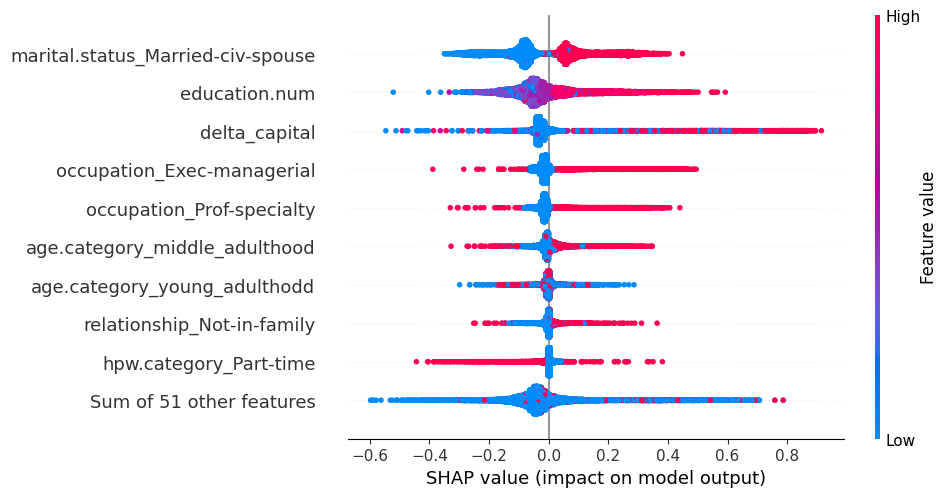

In [16]:
shap.plots.beeswarm(shap_values)

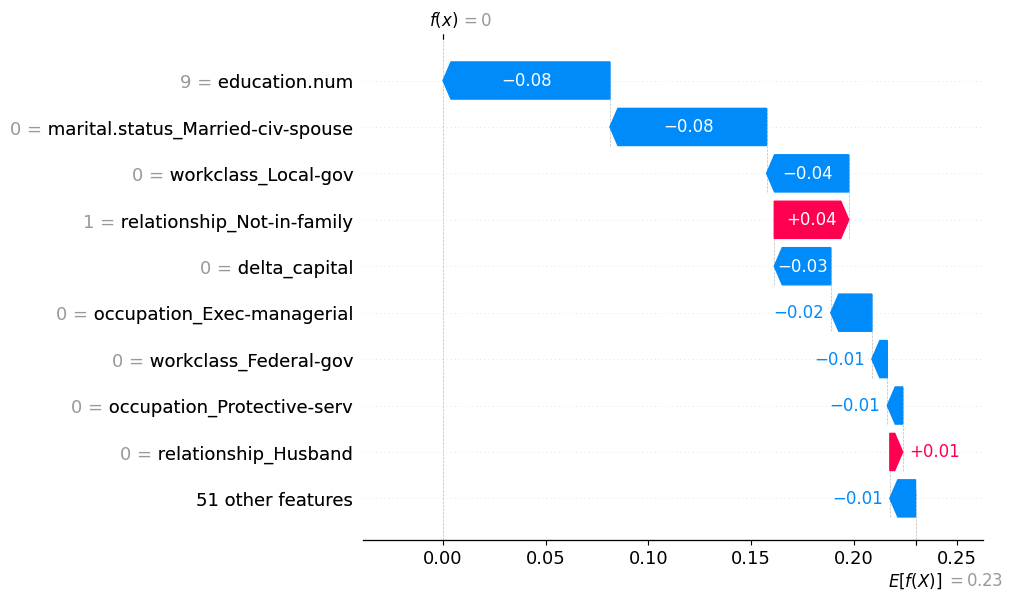

In [17]:
shap.plots.waterfall(shap_values[0])

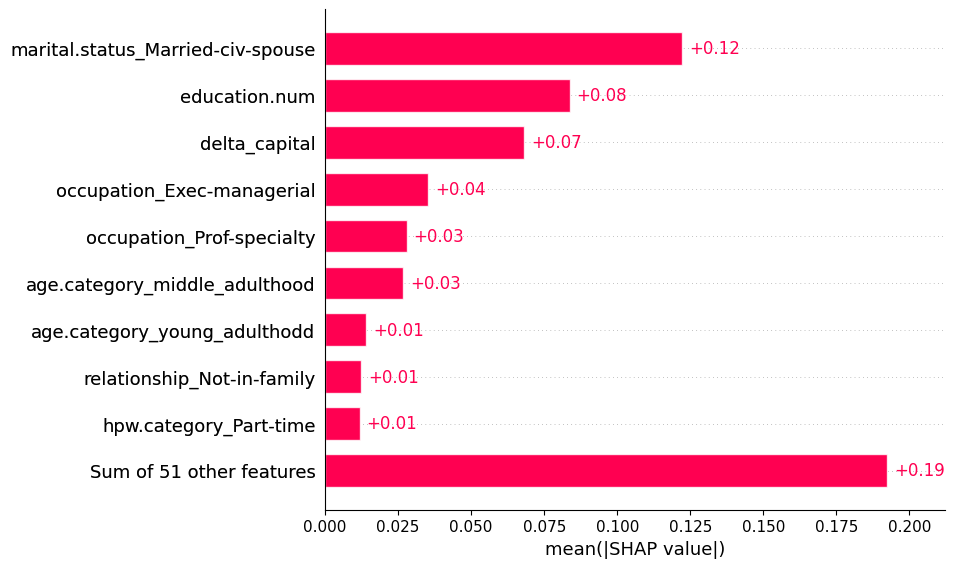

In [18]:
shap.plots.bar(shap_values)

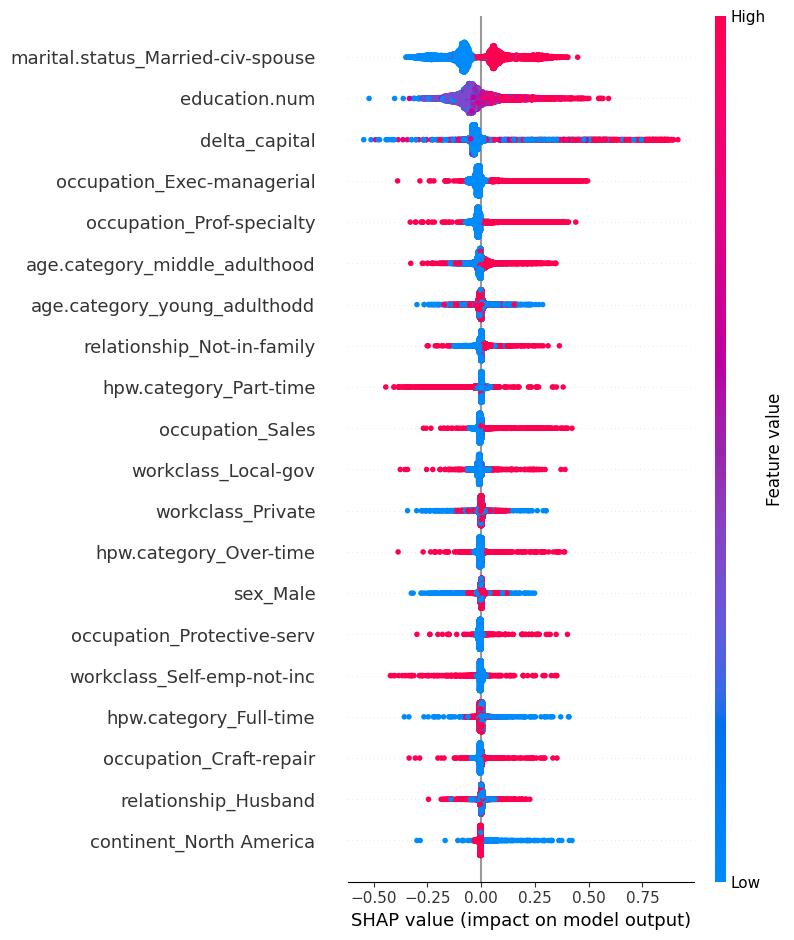

In [19]:
shap.summary_plot(shap_values)